# notebook-001-2
*This notebook was run with Windows 10 Pro (Version 10.0.19041) with the following specs:*

    * Processor: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20 GHz, 2201 Mhz, 10 cores(s), Logical Processor(s)
    * Memory: 64 GB RAM

Here we will demonstrate an example of running image registration using the processed images from the prototype-001 hdiprep notebooks.

First import the necessary modules.

In [2]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [5]:
# import hdi utils module
import hdiutils.HDIimport.hdi_reader as hdi_reader
# import elastix and transformix modules
from miaaim.hdiprep.HDIprep import hdi_prep
from miaaim.hdireg.HDIreg import elastix
from miaaim.hdireg.HDIreg import transformix
# import external modules
import matplotlib.pyplot as plt
import os

Now we will set the path to our processed imaging data and the output folder, and we will read in the imaging data set using the `HDIreader` class from the `hdi-utils` python package. We will then create a dataset using the `HDIprep` module imported above. We will set the path to both the fixed image (the H&E modality) and a moving image (the steady-state UMAP compressed image).

**Note that you do not need to import these modules to run `elastix` and `transformix` from the `hdi-reg` module. We are importing them so that we can easily plot the results of the registration process.**

In [6]:
# set the path to the processed imaging data from hdiprep modules
path_to_fixed = r"D:\Josh_Hess\prototype-001\notebook-output\fixed_processed.nii"
path_to_moving = r"D:\Josh_Hess\prototype-001\notebook-output\moving_processed.nii"
# set the path to the output directory
out_dir = r"D:\Josh_Hess\prototype-001\notebook-output"

# read data with HDIutils
fix_im = hdi_reader.HDIreader(
                    path_to_data=path_to_fixed,
                    path_to_markers=None,
                    flatten=False,
                    subsample=None,
                    mask=False,
                    save_mem=False
                    )
# create data set using HDIprep module
fix_dat = hdi_prep.IntraModalityDataset([fix_im])
# for plotting purposes, extract the key of the data set
fix_key = list(fix_dat.set_dict.keys())[0]

# read data with HDIutils
mov_im = hdi_reader.HDIreader(
                    path_to_data=path_to_moving,
                    path_to_markers=None,
                    flatten=False,
                    subsample=None,
                    mask=False,
                    save_mem=False
                    )
# create data set using HDIprep module
mov_dat = hdi_prep.IntraModalityDataset([mov_im])
# for plotting purposes, extract the key of the data set
mov_key = list(mov_dat.set_dict.keys())[0]

Valid path...
Valid file extension... 
file name: D:\Josh_Hess\prototype-001\notebook-output\fixed_processed.nii 
parsing nifti...
Finished parsing nifti
Finished
Valid path...
Valid file extension... 
file name: D:\Josh_Hess\prototype-001\notebook-output\moving_processed.nii 
parsing nifti...
Finished parsing nifti
Finished


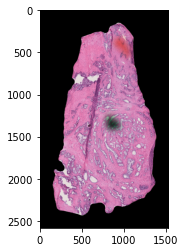

In [7]:
# plot the histology image
plt.imshow(fix_dat.set_dict[fix_key].hdi.data.image)

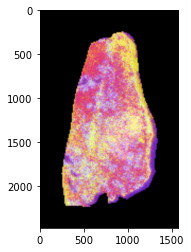

In [8]:
# plot the moving steady state UMAP compressed image (note that we are only showing
# the first three channels in RGB space)
plt.imshow(mov_dat.set_dict[mov_key].hdi.data.image[:,:,:3])

Next, we will register these two images using the HDIreg workflow and the manifold alignment scheme. We will do this by first registering the images using an affine transformation, and then the images will be registered nonlinearly. These are indicated in the `input` folder of `prototype-001` by the `affine.txt` and `nonlinear.txt` parameter files.

First, we set the paths to our parameter files and create a list from the two.

**Note that elastix uses file paths as input rather than any objects from the HDIprep module.**

In [11]:
# set path to affine registration parameters
affine_pars = r"D:\Josh_Hess\prototype-001\input\affine_short.txt"
# set path to affine registration parameters
nonlinear_pars = r"D:\Josh_Hess\prototype-001\input\nonlinear_short.txt"
# concatenate the two parameter files to a list
p = [affine_pars, nonlinear_pars]

Now we can register the images using the `elastix` module.

**Note that there are two pairs of elastix registration parameter files in the `input` folder for `prototype-001`. Here we use the shorter version for registration. The original version took ~1 hour to complete. The short version took ~40min using this dataset. If you are not using a machine with a lot of computing power, consider using the short version, as shown here. The short version was created by changing the number of resolutions and the number of spatial samples in the registration parameter files.**

In [12]:
# run the registration
elastix.Elastix(path_to_fixed,
                path_to_moving,
                out_dir,
                p,
                fp=None,
                mp=None,
                fMask=None
                )

Loading images...
Done loading
Created temporary directory D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo
Exporting single channel images for multichannel input...
elastix -p D:\Josh_Hess\prototype-001\input\affine_short.txt  -p D:\Josh_Hess\prototype-001\input\nonlinear_short.txt -out D:\Josh_Hess\prototype-001\notebook-output -f0 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\fixed_processed0.nii -f1 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\fixed_processed1.nii -f2 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\fixed_processed2.nii -m0 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\moving_processed0.nii -m1 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\moving_processed1.nii -m2 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\moving_processed2.nii -m3 D:\Josh_Hess\prototype-001\notebook-output\tmprwg04guo\moving_processed3.nii
Running elastix...
Finished -- computation took 2527.5535945892334sec.


In the nonlinear parameter file, `nonlinear.txt`, we chose to export a resulting image from elastix after registration using the `WriteResultImage` option. The output of this registration will be labelled with the suffix `.1` since it is the second registration (the first registration would have exported an image with the `.0` suffix). 

We can check the registration results by loading the images into ImageJ/FIJI. Here we exported an overlay of one of the H&E images and the resulting image from elastix. We saved the file as `elastix-fiji-stack.tif`. The cyan channel is the H&E modality, and the magenta channel is a channel from the MSI steady state compressed image.

**Note that elastix will only export the first channel if you using the `WriteResultImage` option. The full image stack can be exported using transformix, which we will show later.**

Valid path...
Valid file extension... 
file name: D:\Josh_Hess\prototype-001\notebook-output\elastix-fiji-stack.tif 
parsing cytometry data...
Finished parsing image data


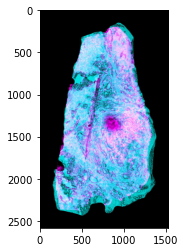

In [13]:
# set path to output image
result_path = r"D:\Josh_Hess\prototype-001\notebook-output\elastix-fiji-stack.tif"
# read the output image stack for registration results
result = hdi_reader.HDIreader(
                    path_to_data=result_path,
                    path_to_markers=None,
                    flatten=False,
                    subsample=None,
                    mask=False,
                    save_mem=False
                    )
# create data set using HDIprep module
result_dat = hdi_prep.IntraModalityDataset([result])
# for plotting purposes, extract the key of the data set
result_key = list(result_dat.set_dict.keys())[0]

# plot the histology image
plt.imshow(result_dat.set_dict[result_key].hdi.data.image)

Now, we can transform the original moving image using the elastix registration transform parameters. These are stored as `TransformParameters.0.txt` and `TransformParameters.1.txt`, again numbered according to the registration used (affine vs. nonlinear). 

We set the path to the image registration parameters, the original moving image, and we set the pad width and target image size that were used during the HDIprep module (see notebook 001). All padding and image resizing is carried out on a per channel basis in `Transformix`.

**Note that running transformix on prototype-001 took ~8min on this machine, transformix 191 channels from the MSI data. The resulting file, `moving_result.nii`, is stored here as a .nii stack, and is ~5.86 GB.**

In [14]:
# set path to moving image
in_im = r"D:\Josh_Hess\prototype-001\input\moving"
# set path to output transform parameter files
tps = [r"D:\Josh_Hess\prototype-001\notebook-output\TransformParameters.0.txt",
        r"D:\Josh_Hess\prototype-001\notebook-output\TransformParameters.1.txt"]
# set target size and padding (see notebook 001 for details)
target_size = (2472,1572)
pad = (20,20)

# transform the set of MSI data
transformix.Transformix(in_im,
                        out_dir,
                        tps,
                        target_size,
                        pad,
                        trim = None,
                        crops = None,
                        out_ext = ".nii"
                        )

Valid path...
Valid file extension... 
file name: D:\Josh_Hess\prototype-001\input\moving\moving.imzML 
parsing imzML...


C:\Users\Ruxandra Sirbulescu\AppData\Roaming\Python\Python37\site-packages\pyimzml\ontology\ontology.py:88: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


Finished parsing imzML
Finished
Detected multichannel input
Created temporary directory D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90
Working on slice 0
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmp5g8xlbf6 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving0.nii
Working on slice 1
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpe8b4644w -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving1.nii
Working on slice 2
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpwe9b60xx -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\proto

Working on slice 27
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmp9hhpbe68 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving27.nii
Working on slice 28
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpfttr4lqj -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving28.nii
Working on slice 29
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpdndv7_t9 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving29.nii
Working on slice 30
Created transform parameters length:1
transformix -out D:\Josh_Hess\

Working on slice 54
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpvh2wbo4_ -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving54.nii
Working on slice 55
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpt8t5a9xn -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving55.nii
Working on slice 56
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmp0mvf2kv3 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving56.nii
Working on slice 57
Created transform parameters length:1
transformix -out D:\Josh_Hess\

Working on slice 81
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpuwnvlm0k -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving81.nii
Working on slice 82
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpwse5vedg -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving82.nii
Working on slice 83
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpfdyy1vj9 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving83.nii
Working on slice 84
Created transform parameters length:1
transformix -out D:\Josh_Hess\

Working on slice 108
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpjdi2y_m9 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving108.nii
Working on slice 109
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmp4yntst77 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving109.nii
Working on slice 110
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmp1jpi6gb0 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving110.nii
Working on slice 111
Created transform parameters length:1
transformix -out D:\Jos

Working on slice 135
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpx7reiaea -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving135.nii
Working on slice 136
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpjytgiiay -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving136.nii
Working on slice 137
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpcmmgbzu_ -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving137.nii
Working on slice 138
Created transform parameters length:1
transformix -out D:\Jos

Working on slice 162
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpzp75th_2 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving162.nii
Working on slice 163
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpnkjqx7m6 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving163.nii
Working on slice 164
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpy8y1a6e_ -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving164.nii
Working on slice 165
Created transform parameters length:1
transformix -out D:\Jos

Working on slice 189
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpm1e1gb79 -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving189.nii
Working on slice 190
Created transform parameters length:1
transformix -out D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\tmpheyez8vz -tp D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\TransformParameters_comp.1.txt -in D:\Josh_Hess\prototype-001\notebook-output\tmprhayce90\moving190.nii
Finished
